<a href="https://colab.research.google.com/github/mohdravi/plant_desease_detection/blob/main/plant_desease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Ingestion

###Step 1:

In [28]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohdraavi","key":"3997af6b8413f8a42d6d83d7d602504f"}'}

###Step 2:

In [29]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

###Step 3:
copy the api command of the dataset

In [32]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [34]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plantdisease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [33]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [41]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/plantvillage'
width=256
height=256
depth=3

In [42]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [51]:
root_dir = listdir(directory_root)
print(root_dir)

['PlantVillage']


In [52]:
plant_disease_folder_list = listdir(f"{directory_root}/{'PlantVillage'}")
print(plant_disease_folder_list)

['Tomato_Septoria_leaf_spot', 'Potato___Early_blight', 'Tomato_healthy', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Potato___Late_blight', 'Tomato__Tomato_mosaic_virus', 'Pepper__bell___Bacterial_spot', 'Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Pepper__bell___healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Potato___healthy']


In [ ]:
plant_disease_folder_list = listdir(f"{directory_root}/{'PlantVillage'}")

In [54]:
# plant_disease_folder_list
listdir(f"{directory_root}/{'PlantVillage'}/{'Tomato_Septoria_leaf_spot'}/")

['0b6a9374-858d-49ce-8a94-ab57c957718c___Matt.S_CG 2488.JPG',
 '6cd819ce-a0e5-46b4-b0ed-1991580f0fd4___Matt.S_CG 2493.JPG',
 '28658cdf-b9a4-4f11-8e50-3793211600f3___Matt.S_CG 6487.JPG',
 '4e91dd84-5a88-4b2f-8c08-b48a1c0bfc4c___Matt.S_CG 6575.JPG',
 'c06b05f0-b428-45ee-bc9f-df042d171e81___JR_Sept.L.S 8529.JPG',
 '833718f3-b599-4fc3-b7da-fb60c9a0d190___Matt.S_CG 0934.JPG',
 '2f8bcf08-19de-4aa3-a60d-fa6593a53359___JR_Sept.L.S 2679.JPG',
 'f56fd18d-3880-4e20-81e2-ac0f91804226___Keller.St_CG 1929.JPG',
 '002533c1-722b-44e5-9d2e-91f7747b2543___Keller.St_CG 1831.JPG',
 'b06c3d4e-04cf-4eff-82fa-4553264a21e0___JR_Sept.L.S 2615.JPG',
 'e286fcac-d0a5-4333-bba7-9ddcbaaaf17c___JR_Sept.L.S 8521.JPG',
 '1c7bc7c5-daec-45bd-beb9-89beb159c755___Keller.St_CG 2018.JPG',
 '77c5b76c-3b81-4174-892d-640c97ba7f48___JR_Sept.L.S 2714.JPG',
 '599a27e9-9552-4bad-b478-010bdb56172f___Matt.S_CG 2800.JPG',
 '67d141c6-be7a-4f3d-9c4f-b667ca41ebd4___Keller.St_CG 1838.JPG',
 '84836cba-6362-4e3b-b86c-d84f91d186ce___JR_Sept

In [43]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Potato___healthy ...
[INFO] Image loading completed


In [96]:
# #experiment works
# import cv2
# from google.colab.patches import cv2_imshow
# # Load the image
# image = cv2.imread("/content/plantvillage/PlantVillage/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG")
# print('iamge : ' ,image)

# # Display the image
# cv2_imshow(image)

# # # Wait for the user to press a key
# # cv2.waitKey(0)

# # # Close all windows
# # cv2.destroyAllWindows()

#2. Preprocessing

###Encoding

In [57]:
image_size = len(image_list)

In [60]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [64]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [65]:
image_list

[array([[[132., 115., 128.],
         [145., 128., 141.],
         [148., 131., 144.],
         ...,
         [142., 125., 139.],
         [139., 122., 136.],
         [139., 122., 136.]],
 
        [[130., 113., 126.],
         [127., 110., 123.],
         [147., 130., 143.],
         ...,
         [ 95.,  78.,  92.],
         [141., 124., 138.],
         [ 97.,  80.,  94.]],
 
        [[141., 124., 137.],
         [130., 113., 126.],
         [165., 148., 161.],
         ...,
         [160., 143., 157.],
         [106.,  89., 103.],
         [167., 150., 164.]],
 
        ...,
 
        [[144., 128., 145.],
         [164., 148., 165.],
         [158., 142., 159.],
         ...,
         [134., 123., 139.],
         [108.,  97., 113.],
         [127., 116., 132.]],
 
        [[154., 138., 155.],
         [125., 109., 126.],
         [145., 129., 146.],
         ...,
         [111., 100., 116.],
         [125., 114., 130.],
         [117., 106., 122.]],
 
        [[124., 108., 125.],
 

###Data Scaling

In [66]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

###Data Splitting

In [68]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [71]:
x_train.shape

(2361, 256, 256, 3)

In [70]:
x_test.shape

(591, 256, 256, 3)

In [72]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [73]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [77]:
import tensorflow as tf

In [79]:
decay=INIT_LR / EPOCHS

In [80]:
import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=10000,
    decay_rate=decay)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [81]:
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [82]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

<ipython-input-82-f5a41846f0f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
73/73 [==============================] - 55s 583ms/step - loss: 0.6265 - accuracy: 0.2035 - val_loss: 0.4281 - val_accuracy: 0.0677
Epoch 2/25
73/73 [==============================] - 40s 552ms/step - loss: 0.2285 - accuracy: 0.3950 - val_loss: 1.6243 - val_accuracy: 0.0660
Epoch 3/25
73/73 [==============================] - 38s 515ms/step - loss: 0.1558 - accuracy: 0.5698 - val_loss: 2.0348 - val_accuracy: 0.0643
Epoch 4/25
73/73 [==============================] - 37s 503ms/step - loss: 0.1429 - accuracy: 0.6256 - val_loss: 0.5332 - val_accuracy: 0.1557
Epoch 5/25
73/73 [==============================] - 38s 519ms/step - loss: 0.1237 - accuracy: 0.6814 - val_loss: 0.5843 - val_accuracy: 0.0795
Epoch 6/25
73/73 [==============================] - 39s 529ms/step - loss: 0.1112 - accuracy: 0.7226 - val_loss: 0.5342 - val_accuracy: 0.0778
Epoch 7/25
73/73 [==============================] - 37s 500ms/step - loss: 0.1038 - accuracy: 0.7282 - val_loss: 0.3590 - val_accuracy: 0.2504

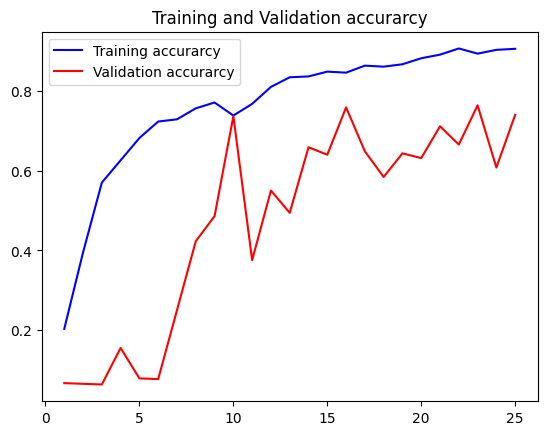

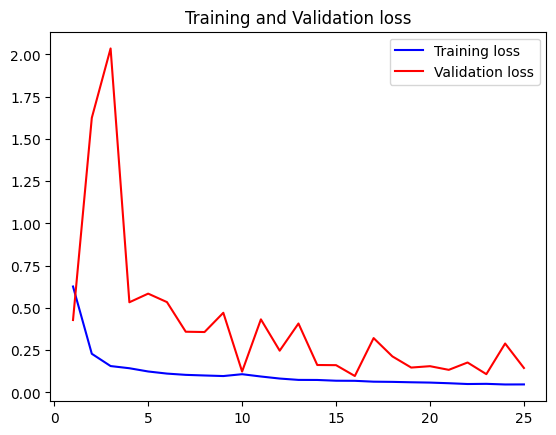

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [90]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 1s 34ms/step - loss: 0.1443 - accuracy: 0.7394
Test Accuracy: 73.94247055053711


In [91]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


#prediction pipeline

img_array :  [[[[0.49019608 0.4745098  0.4627451 ]
   [0.4862745  0.47058824 0.45882353]
   [0.4862745  0.47058824 0.45882353]
   ...
   [0.4862745  0.48235294 0.4745098 ]
   [0.47843137 0.4745098  0.46666667]
   [0.46666667 0.4627451  0.45490196]]

  [[0.45882353 0.44313726 0.43137255]
   [0.4745098  0.45882353 0.44705883]
   [0.49411765 0.47843137 0.46666667]
   ...
   [0.4745098  0.47058824 0.4627451 ]
   [0.47058824 0.46666667 0.45882353]
   [0.4627451  0.45882353 0.4509804 ]]

  [[0.48235294 0.46666667 0.45490196]
   [0.47843137 0.4627451  0.4509804 ]
   [0.47058824 0.45490196 0.44313726]
   ...
   [0.44313726 0.4392157  0.43137255]
   [0.43529412 0.43137255 0.42352942]
   [0.42745098 0.42352942 0.41568628]]

  ...

  [[0.54901963 0.5568628  0.5529412 ]
   [0.56078434 0.5686275  0.5647059 ]
   [0.5764706  0.58431375 0.5803922 ]
   ...
   [0.6117647  0.6156863  0.62352943]
   [0.6117647  0.6156863  0.62352943]
   [0.6117647  0.6156863  0.62352943]]

  [[0.57254905 0.5803922  0.5764

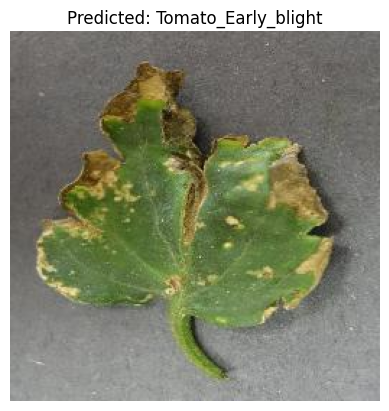

In [95]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Assume 'model' is your trained model
# and 'label_binarizer' is your label encoder (e.g., LabelBinarizer())

# Function to load and preprocess image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image
    print('img_array : ', img_array)
    return img_array

# Path to the image you want to predict
img_path = '/content/00639d29-2d1a-4fcf-9bd3-a2b3109c74c4___UF.GRC_BS_Lab Leaf 1054.JPG'

# Load and preprocess the image
img_array = load_and_preprocess_image(img_path, target_size=(height, width))

# Make a prediction
predictions = model.predict(img_array)
print('predictions : ', predictions)
# Decode the predictions
predicted_class = np.argmax(predictions, axis=1)
predicted_label = label_binarizer.classes_[predicted_class][0]

# Print the prediction
print(f"Predicted label: {predicted_label}")

# Display the image with predicted label
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()